In [88]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
# Define the Cosmology here
'''
# WMAP1 Cosmology
Om     0.270
Ob     0.046
OL     0.730
sigma_8     0.90
h           0.72
ns          0.99
'''

#'''
# Aseem's Cosmology
sigma_8=0.811
ns=0.961
h=0.7
Ob=0.045
Om=0.276
#'''

In [90]:
# Constants and important parameters
M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
z=0.0         # Redshift specification
Delta=200.0   # Overdensity definition = Delta X background
rho_cr=((3*(100*h)**2)/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=Om*rho_cr*((1+z)**3)  # where a=1/(1+z)   Units same as rho_cr
del_crit=1.69
M_min=2.6765e+11  # Units of Msun/h
M_max=6.0536e+11  # Units of Msun/h

In [91]:
# Input data : Normalised Power spectrum
#PS=np.loadtxt("./../Data/power_spectrum_camb_su1024_cosmology.txt")
PS=np.loadtxt("./../Normalize PS/NormalizedDimensionlessPS.txt")
k=PS[:,0]
ps=PS[:,1]/(1+z)**2   # Dimensionless PS = k^3*P(k)/2Pi^2 at redshift z

In [119]:
# Smoothing window functions Fourier Transformed in k-space
def TopHat(k,R):
    return (3.0/(k*R)**3)*(np.sin(k*R)-(k*R)*np.cos(k*R))

def TopHat_derv(k,R):
    return (-3.0*TopHat(k,R)/(k*R))+(3.0*np.sin(k*R)/(k*R)**2)

def Gaussian(k,R):
    return np.exp(-0.5*(k*R)**2)

def Gaussian_derv(k,R):
    return (-k*R)*Gaussian(k,R)

In [120]:
# The smoothing scale R as a function of M. M to be passed in units M_sun/h. R returned will be in MPc/h 
# k is in units h/MPc, therefore kR will be unitless in the smoothening window
const1=np.cbrt(3.0/(4.0*np.pi*rho_m))
def R(M):
    return const1*np.cbrt(M)

In [121]:
# The rms variance of the linear density field smoothed on scale R(M)
# Requires inputs on mass of halo in M_sun (to define R(M)) and the smoothing window type
# Fourier modes 'k' are interpreted from the Power Spectrum by default.

def sigma(M,W="TopHat"):
    r=np.array(R(M))
    result=[]
    
    for i in range(0,len(r)):
        window=[]
        if(W=="TopHat"):
            window=TopHat(k,r[i])
        if(W=="Gaussian"):
            window=Gaussian(k,r[i])

        window=np.array(window)
        function=ps*(window**2)
        result.append(np.trapz(function,np.log(k)))
    
    return np.array(result)

In [122]:
# From Aseem's trick to computing d(sigma^2)/dR
def sigma_derv(M,W='TopHat'):
    r=np.array(R(M))
    result=[]
    
    for i in range(0,len(r)):
        window,derv=[],[]
        if(W=="TopHat"):
            window=TopHat(k,r[i])
            derv=TopHat_derv(k,r[i])
        if(W=="Gaussian"):
            window=Gaussian(k,r[i])
            derv=Gaussian_derv(k,r[i])
        window=np.array(window)
        derv=np.array(derv)

        function=2.0*ps*window*k*derv
        result.append(np.trapz(function,np.log(k)))
    
    return np.array(result)

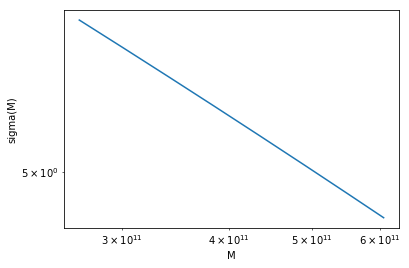

In [124]:
Mb=np.linspace(M_min,M_max,1000)
s=sigma(Mb)
plt.plot(Mb,s,markersize=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M")
plt.ylabel("sigma(M)")
plt.show()

In [125]:
# Parameters according to those given in the Tinker2008 paper [https://arxiv.org/pdf/0803.2706.pdf]
params=np.loadtxt("./param.txt")
d=np.where(params[:,0]==Delta)
A=float(params[d,1])*np.power((1+z),-0.14)
a=float(params[d,2])*np.power((1+z),-0.06)
alpha=np.exp(-1.0*(0.75/np.log(Delta/75)**1.2))    # required for Redshift evolution of parameter 'b'
b=float(params[d,3])*np.power((1+z),-1.0*alpha)
c=float(params[d,4])

In [126]:
# This function finds the Tinker Universal fit for the Halo Mass function f(sigma)
# It uses the Tinker parameters and argument is M in units M_sun

def f(M):
    s_sq=sigma(M,W="TopHat")
    s=np.sqrt(s_sq)
    term0=s/b
    term1=1.0+np.power(term0,-1.0*a)
    term2=A*term1*np.exp(-1.0*c/s_sq)
    return term2

In [130]:
# This function returns the Tinker mass function dn/dm.
# 30 bins are created by defualt between M_min and M_max as defined in the preamble above unless specified otherwise
# Returns an array of number of Halos populating each logarithmic mass bin i.e return dn/dlnm

def TMF(numOfBins=100,M_lower=-1,M_upper=-1):
    massBins=[]
    if(M_lower==-1 or M_upper==-1):
        print("Invalid upper or lower limit on the mass of halos")
        exit()
    else:
        last=np.log(M_upper/M_lower)
        massBins=M_lower*np.exp(np.linspace(0.0,last,numOfBins))    # Log spaced mass 
    massBins=np.array(massBins)

    term1=f(massBins)   # term1 of TMF
    term2=rho_m/massBins   # term2 of TMF
    
    sig=sigma(massBins)
    sig_derv=sigma_derv(massBins)
    
    # dln(sigma^-1)/dlnM = -(R/6sigma^2)*d(sigma^2)/dR | d(sigma^2)/dR=sig_derv   ==> Aseem's Trick
    term3_1=R(massBins)*sig_derv/(-6.0*sig)    # term 3 of TMF
    term3_2=np.gradient(-1.0*np.log(np.sqrt(sig)),np.log(massBins))   # The direct derivative

    result=(term1*term2*term3_1)
    return result,massBins

In [131]:
# Plotting and comparing with Tinker MF Graph in the paper
M_lower=1e+12
M_upper=1e+16
nOB=1000
res,m_mid=TMF(nOB,M_lower,M_upper)

In [138]:
adiMF=np.interp([1e12,1e13,1e14],m_mid,res)
asMF=np.array([3.73723734e-03, 4.66887341e-04, 3.97387960e-05])
print(asMF/adiMF)

[1.00525161 1.00234644 0.99317271]


In [133]:
# Computation of Tinker Bias as a function of Nu(or Sigma) and the parameters as described in the paper
# Parameters with the underscore are the Bias parameters and those without are the mass function parameters
y_=np.log10(Delta)
util1_=np.exp(-1.0*(4/y_)**4)
A_=1.0+(0.24*y_*util1_)
a_=0.44*y_-0.88
B_=0.183
b_=1.5
C_=0.019+(0.107*y_)+(0.19*util1_)
c_=2.4

def bias(M):
    nu=del_crit/np.sqrt(sigma(M))
    term1=A_*nu**a_/(nu**a_ + del_crit**a_)
    term2=B_*nu**b_
    term3=C_*nu**c_
    return 1.0-term1+term2+term3

In [139]:
res2=bias(m_mid)
adiBias=np.interp([1e12,1e13,1e14],m_mid,res2)
asBias=np.array([0.83173894, 1.15849428, 2.14696038])
print(asBias/adiBias)

[0.99824447 0.99726303 0.99609459]
